# Baseline

In [1]:
import kagglehub
import numpy as np
import pandas as pd 
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# test = pd.read_csv("./../data/CICIDS_converted_data.csv")

In [3]:
# test.head()

In [4]:
# Download dataset
base_path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")

files = [os.path.join(base_path, f) for f in os.listdir(base_path)]
print("Total files:", len(files))


Total files: 8


In [5]:
df_list = []

for file in files:
    print("Reading:", file)
    df = pd.read_csv(file)
    df_list.append(df)

full_df = pd.concat(df_list, ignore_index=True)

print("Full Shape:", full_df.shape)

Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Monday-WorkingHours.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Tuesday-WorkingHours.pcap_IS

In [6]:
full_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
print("Before cleaning:", full_df.shape)
full_df.columns = full_df.columns.str.strip()

# Remove duplicates
full_df.drop_duplicates(inplace=True)

## Duplicate Column and Destination Port; Removal
full_df.drop(columns=["Fwd Header Length.1", "Destination Port"], inplace=True)

# Replace infinity values with NaN
full_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop missing values
full_df.dropna(inplace=True)

print("After cleaning:", full_df.shape)

Before cleaning: (2830743, 79)
After cleaning: (2520798, 77)


In [8]:
print(full_df['Label'].value_counts())

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [21]:
# Filter dataset
labels = ['BENIGN', 'DoS Hulk']
binary_df = full_df[full_df['Label'].isin(labels)].copy()

print("Class distribution after filtering:")
print(binary_df['Label'].value_counts())

Class distribution after filtering:
Label
BENIGN      2095057
DoS Hulk     172846
Name: count, dtype: int64


In [10]:
X_full = binary_df.drop('Label', axis=1)
y_full = binary_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    stratify=y_full,
    test_size=0.1,
    random_state=42
)

print("Train label distribution (before balancing):")
print(y_train.value_counts())

Train label distribution (before balancing):
Label
BENIGN      1885551
DoS Hulk     155561
Name: count, dtype: int64


In [11]:
# Balance ONLY the training set (downsample the majority class to match the minority)

train_df = X_train.copy()
train_df['Label'] = y_train.values

counts = train_df['Label'].value_counts()
dos_hulk_counts = counts.min()

dos_hulk_df = train_df[train_df['Label'] == 'DoS Hulk']
benign_sampled_df = train_df[train_df['Label'] == 'BENIGN'].sample(n=dos_hulk_counts, random_state=42)

balanced_train_df = pd.concat([dos_hulk_df, benign_sampled_df], ignore_index=True).sample(frac=1, random_state=42)

In [12]:
X_train_balanced = balanced_train_df.drop('Label', axis=1)
y_train_balanced = balanced_train_df['Label']

print("X_train_balanced shape:", X_train_balanced.shape)
print("y_train_balanced distribution:")
print(y_train_balanced.value_counts())

X_train_balanced shape: (311122, 76)
y_train_balanced distribution:
Label
DoS Hulk    155561
BENIGN      155561
Name: count, dtype: int64


In [20]:
os.makedirs('models', exist_ok=True)

total_trees = 100
step = 10

clf = RandomForestClassifier(n_estimators=step, warm_start=True, n_jobs=-1, random_state=42)
start = time.time()
for n in range(step, total_trees + 1, step):
    clf.set_params(n_estimators=n)
    clf.fit(X_train_balanced, y_train_balanced)
    elapsed = time.time() - start
    print(f"Trained {n}/{total_trees} trees ({n/total_trees*100:.1f}%), elapsed {elapsed:.1f}s")

Trained 10/100 trees (10.0%), elapsed 2.0s
Trained 20/100 trees (20.0%), elapsed 3.7s
Trained 30/100 trees (30.0%), elapsed 5.7s
Trained 40/100 trees (40.0%), elapsed 7.5s
Trained 50/100 trees (50.0%), elapsed 9.4s
Trained 60/100 trees (60.0%), elapsed 11.2s
Trained 70/100 trees (70.0%), elapsed 13.1s
Trained 80/100 trees (80.0%), elapsed 14.9s
Trained 90/100 trees (90.0%), elapsed 16.6s
Trained 100/100 trees (100.0%), elapsed 18.3s


Classification report:
               precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    209506
    DoS Hulk       0.99      1.00      0.99     17285

    accuracy                           1.00    226791
   macro avg       0.99      1.00      1.00    226791
weighted avg       1.00      1.00      1.00    226791



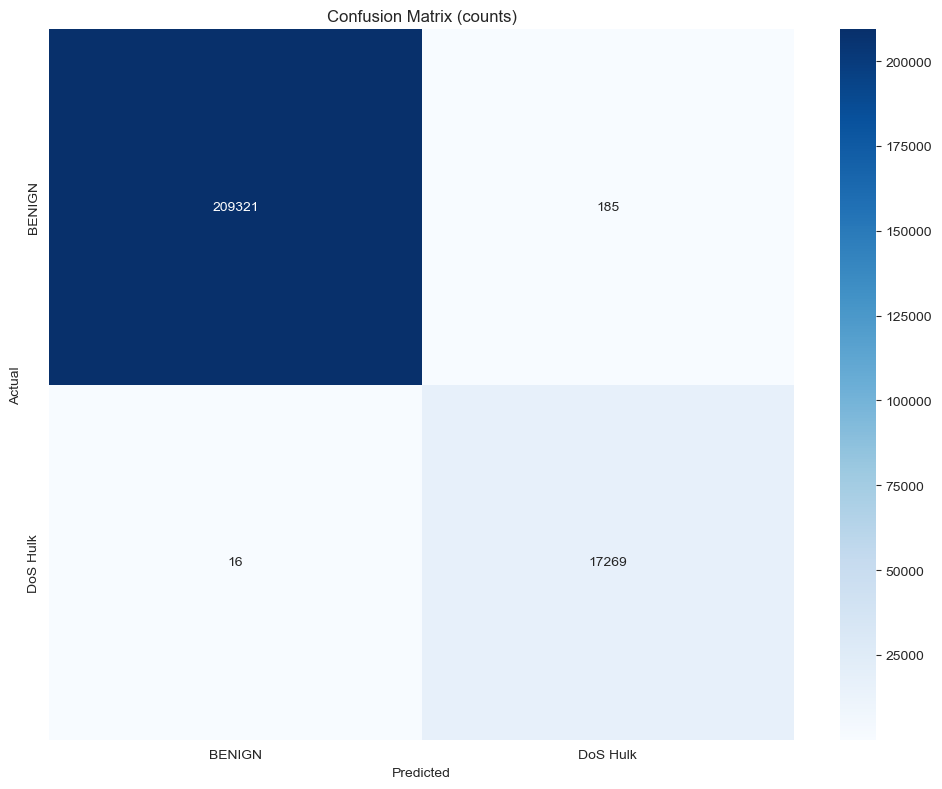

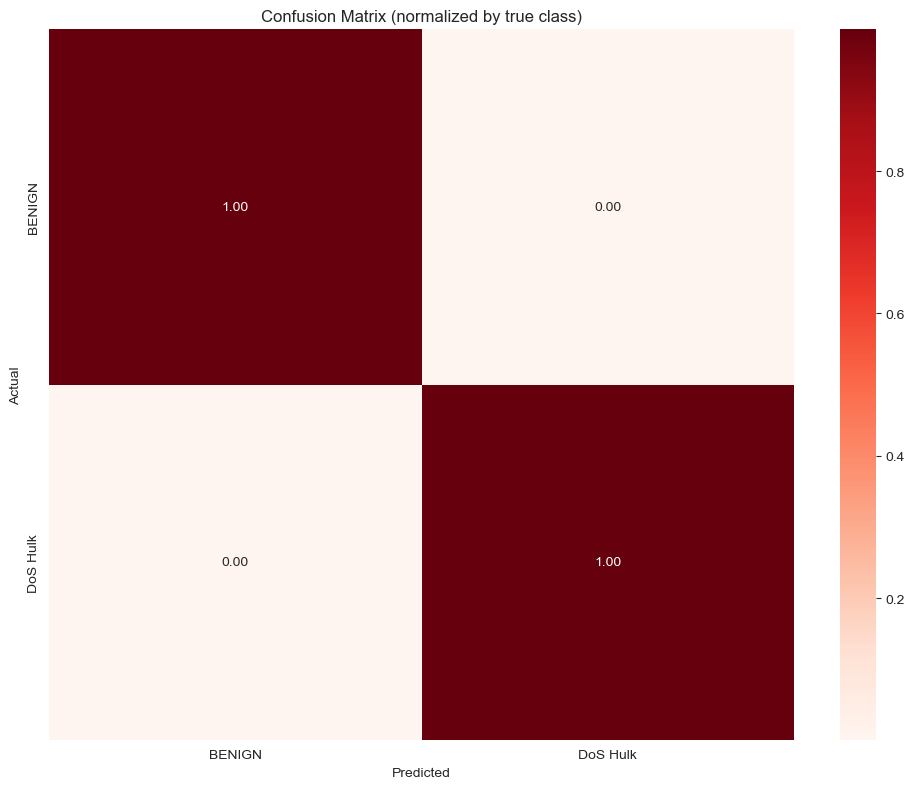

In [22]:
y_pred = clf.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred, labels=labels))

# Confusion matrix (counts and normalized)
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(np.concatenate([y_test, y_pred]).astype(str))

# Plot raw counts
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (counts)")
plt.tight_layout()
os.makedirs('models', exist_ok=True)
plt.show()

# Plot normalized (by true label / rows)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-12)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (normalized by true class)")
plt.tight_layout()
plt.show()

In [17]:
# Save model + encoders
os.makedirs('models', exist_ok=True)
out_path = 'models/random_forest.joblib'
joblib.dump({
    'model': clf
}, out_path)
print("Saved model to", out_path)

Saved model to baseline/models/random_forest.joblib
